<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Exploratory Data Analysis on a Natural Language Processing Task
> Authors: Caroline Schmitt, Matt Brems

---

Exploratory data analysis (EDA) is a crucial part of any data science project. EDA helps us discover interesting relationships in the data, detect outliers and errors, examine our own assumptions about the data, and prepare for modeling. During EDA we might discover that we need to clean our data more conscientiously, or that we have more missing data than we realized, or that there aren't many patterns in the data (indicating that modeling may be challenging.)

In this lab you'll bring in a natural language dataset and perform EDA. The dataset contains Facebook statuses taken from between 2009 and 2011 as well as personality test results associated with the users whose Facebook statuses are included.

This dataset uses results from the Big Five Personality Test, also referred to as the five-factor model, which measures a person's score on five dimensions of personality:
- **O**penness
- **C**onscientiousness
- **E**xtroversion
- **A**greeableness
- **N**euroticism

Notoriously, the political consulting group Cambridge Analytica claims to have predicted the personalities of Facebook users by using those users' data, with the goal of targeting them with political ads that would be particularly persuasive given their personality type. Cambridge Analytica claims to have considered 32 unique 'groups' in the following fashion:
- For each of the five OCEAN qualities, a user is categorized as either 'yes' or 'no'.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$).

Cambridge Analytica's methodology was then, roughly, the following:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big Five personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

In this lab you will perform EDA to examine many relationships in the data.

Exploratory data analysis can be a non-linear process, and you're encouraged to explore questions that occur to you as you work through the notebook.

> **Content note**: This dataset contains real Facebook statuses scraped from 2009 to 2011, and some of the statuses contain language that is not safe for work, crude, or offensive. The full dataset is available as `mypersonality.csv`, and a sanitized version containing only statuses that passed an automated profanity check is available as `mypersonality_noprofanity.csv`. Please do not hesitate to use `mypersonality_noprofanity.csv` if you would prefer to. Please note that the automated profanity check is not foolproof. If you have any concerns about working with this dataset, please get in touch with your instructional team.

---

### External resources

These resources are not required reading but may be of use or interest.

- [Python Graph Gallery](https://python-graph-gallery.com/)
- [Wikipedia page](https://en.wikipedia.org/wiki/Big_Five_personality_traits) on the Big Five test
- [A short (3-4 pages) academic paper](./celli-al_wcpr13.pdf) using the `MyPersonality` dataset to model personality

---

## Load packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

# This setting widens how many characters pandas will display 
# in a column:
pd.options.display.max_colwidth = 400

---

## Load data

In [2]:
df = pd.read_csv('data/mypersonality.csv')

# NOTICE! Do read the commented out code below...
# df = pd.read_csv('data/mypersonality_noprofanity.csv') 
# comment out above & 
# uncomment this to use mypersonality_noprofanity.csv if it 
# makes you more comfortable

df.drop(columns=['NETWORKSIZE', 'BETWEENNESS', 'NBETWEENNESS', 
                 'DENSITY', 'BROKERAGE', 'NBROKERAGE', 
                 'TRANSITIVITY'], inplace=True)
df.head(3)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM


In [3]:
# Check shape of DataFrame
df.shape

(9916, 13)

In [4]:
# Check type of data
df.dtypes

#AUTHID     object
STATUS      object
sEXT       float64
sNEU       float64
sAGR       float64
sCON       float64
sOPN       float64
cEXT        object
cNEU        object
cAGR        object
cCON        object
cOPN        object
DATE        object
dtype: object

In [5]:
# Check missing value
df.isnull().sum()[df.isnull().sum() != 0]

Series([], dtype: int64)

---

## EDA on Statuses

Before we even vectorize the text, we might look at the lengths and word counts in each Facebook status.

**Create a new column called `status_length` that contains the length of each status:**

In [6]:
df.columns

Index(['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN', 'DATE'],
      dtype='object')

In [7]:
# Chain columns name to access columns and using str accessor for using 
# .len() method to find length of status
# And assign length of status to new column name 'status_length'
df['status_length'] = df.STATUS.str.len()

In [8]:
# Check the result: Should contain 'status_length' column
df.head(1)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27


**Create a new column called `status_word_count` that contains the number of words in each status:**

Note: You can evaluate this based off of how many strings are separated by whitespaces; you're not required to check that each set of characters set apart by whitespaces is a word in the dictionary.

In [9]:
# Chain columns name to access columns and using str accessor for using 
# .count() method to count whitespaces of status
# And assign count + 1 (#word = whitespaces + 1)
# to new column name 'status_word_count'
df['status_word_count'] = df.STATUS.str.count(' ') + 1

In [10]:
# Check the result: Should contain 'status_word_count' column
df.head(1)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27,5


### Longest and shortest statuses

Looking at individual observations can help us get a sense of what the dataset contains.

**Show the five longest and five shortest statuses based off of `status_word_count`:**

In [11]:
# Five shortest status
df.sort_values(by='status_word_count')[['STATUS','status_word_count']].head(5)

,STATUS,status_word_count
8316,*PROPNAME*'s?,1
7614,http:////ca.news.yahoo.com//s//capress//091008//world//eu_nobel_literature,1
9099,no,1
229,MLIG!!!,1
4014,2010,1


In [12]:
# Five longest status
df.sort_values(by='status_word_count')[['STATUS','status_word_count']].tail(5)

,STATUS,status_word_count
6989,"If I wear makeup, I'm fake. If I like to get dressed up, I'm a Tart. If I say what i think, I'm a bitch. If I cry sometimes, I'm a drama queen. If I have guy friends, I'm a slut. If I stand up for myself, I'm mouthy. Seems like you can't do anything now a days without being labeled.. So what, go ahead and label me, see if i give a shit. Repost this if your proud of who you are! x x",85
2399,And you run and you run to catch up with the sun but it's sinking. Racing around to come up behind you again. The sun is the same in a relative way but you're older. Shorter of breath and one day closer to death.,86
5680,"I always make it a rule to let the other fellow fire first. If a man wants to fight, I argue the question with him and try to show him how foolish it would be. If he can't be dissuaded, why then the fun begins but I always let him have first crack. Then when I fire, you see, I have the verdict of self-defence on my side. I know that he is pretty certain in his hurry, to miss. I never do.",88
496,"Exact words when renewing DL: Me: Oh no, you can't take my license, It's my 25th b-day. How am I going to get into the bar? DMV: We gonna give you a new one over there Me: But, it won't have my picture and stuff on it. Dmv: Hold up, we can take a picture of your picture and put it on a license i think. (yelling at co-worker to see if this can be done) Yup! Me: So, I can go to the bar?! Dmv: ...",91
2188,"just found an organization called Think Before You Speak that flips out about people saying, ""that's gay,"" claiming that it's offensive. That's pretty gay, if you ask me.",113


## What's the distribution of post lengths?

Use visuals to show the distributions of post lengths. Show both the distribution of word counts and the distribution of lengths based off character.

Skew of the distribution of status length based on character: 1.93
Skew of the distribution of status length based on words counts: 1.99


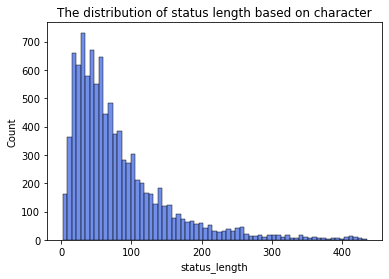

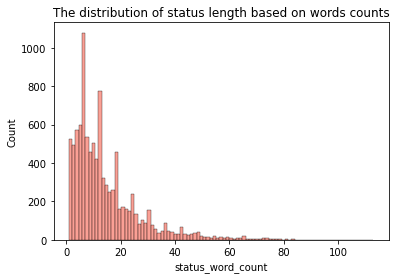

In [13]:
plt.figure()
sns.histplot(data = df['status_length'], color = 'royalblue')
plt.title('The distribution of status length based on character')
print(f"Skew of the distribution of status length based on character: {df['status_length'].skew().round(2)}")
plt.figure()
sns.histplot(data = df['status_word_count'], color = 'salmon')
plt.title('The distribution of status length based on words counts')
print(f"Skew of the distribution of status length based on words counts: {df['status_word_count'].skew().round(2)}");

---

## EDA of Personality Scores

There are two sets of personality columns in the dataset: class and score. According to the attached paper, scores have been converted to categories based on whether a score for a user fell above or below the median.

### Plot the distributions of personality scores for all five score columns:

In [14]:
df.columns

Index(['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN', 'DATE', 'status_length',
       'status_word_count'],
      dtype='object')

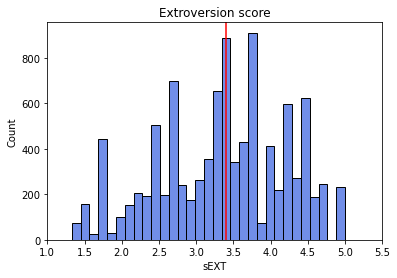

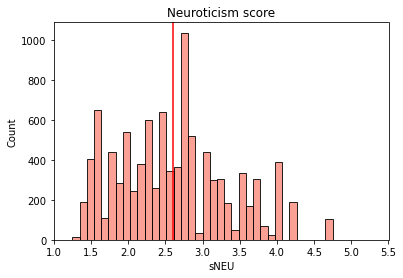

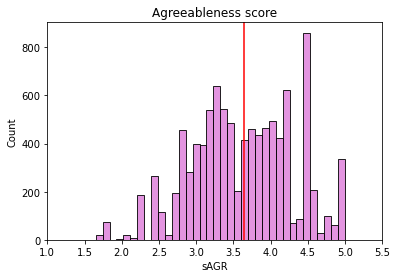

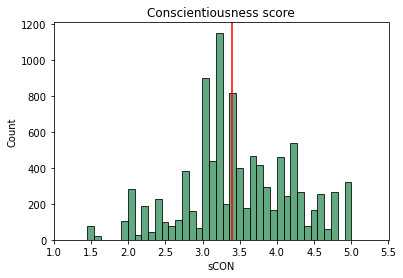

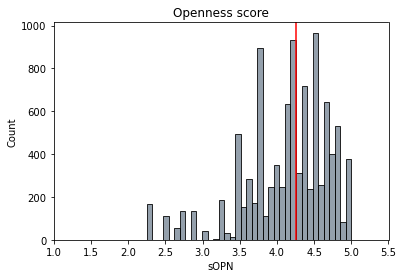

In [15]:
score_list = ['sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN']
title_list = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
color_list = ['royalblue', 'salmon', 'orchid', 'seagreen', 'slategray']
for col, color, title in zip(score_list, color_list, title_list):
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], color=color)
    plt.title(f"{title} score")
    # Red line is median of the data
    plt.axvline(x=df[col].median(), ymin = 0, ymax = 900, color = 'r' )
    plt.xlim(1,5.5)

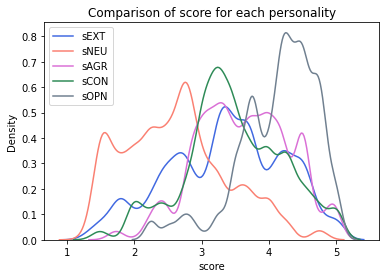

In [71]:
# Compare all personality score with displot
for i, col in enumerate(score_list):
    sns.kdeplot(x=col, 
                data=df, 
                color=color_list[i],
                label=col)
plt.xlabel('score')
plt.title('Comparison of score for each personality')
plt.legend();

---

### How many unique users exist in the dataset?

This dataset has redacted original poster names, but each user is given an `#AUTHID`. How many unique users are there, and how many posts per user do we have?

In [16]:
# Using .nunique method to find # unique user
df['#AUTHID'].nunique()

250

## EDA on unique users

Because we have many posts per user for most users, doing EDA on the personality score columns might be misleading. If we have 200 Facebook statuses from one very high-conscientiousness user, a bar chart of how many `'cCON'` statuses are associated with `'y'` might be misleading. We'll have to be careful about labeling and titling any visualizations we make off of the dataset.

**Create a new dataframe called `unique_users` that only contains the `#AUTHID`, personality score, and personality category columns:**

If you do this correctly, it should have 250 rows and 11 columns.

(Hint: You can use the pandas [drop_duplicates()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) method to make this easier. The only column you want to consider when deciding if a user is duplicated is the `#AUTHID` column.)

In [17]:
df.columns

Index(['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN', 'DATE', 'status_length',
       'status_word_count'],
      dtype='object')

In [18]:
unique_users = df.drop(columns=['STATUS','DATE','status_length','status_word_count']).drop_duplicates()
unique_users.head()

,#AUTHID,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN
0,b7b7764cfa1c523e4e93ab2a79a946c4,2.65,3.00,3.15,3.25,4.40,n,y,n,n,y
102,318bf822d4f2bd3920367560218619c0,4.50,4.00,3.00,4.50,3.75,y,y,n,y,n
171,ecbddbfe00e0f83cfdb802a7186061c7,4.30,2.15,3.60,3.30,4.10,y,n,y,n,y
236,db39f7b2aad360b1033ec1f8fcd57f9c,4.65,3.20,3.05,3.65,4.75,y,y,n,y,y
246,4d035bd3fd8d9595d15cea9e388964be,3.70,2.90,3.40,3.35,4.05,y,y,n,n,y


**Plot the distribution of personality scores for `unique_users`:**

Do the distributions look different? Here, each individual user will only be represented once.

In [19]:
score_list = ['sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN']
title_list = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
color_list = ['royalblue', 'salmon', 'orchid', 'seagreen', 'slategray']

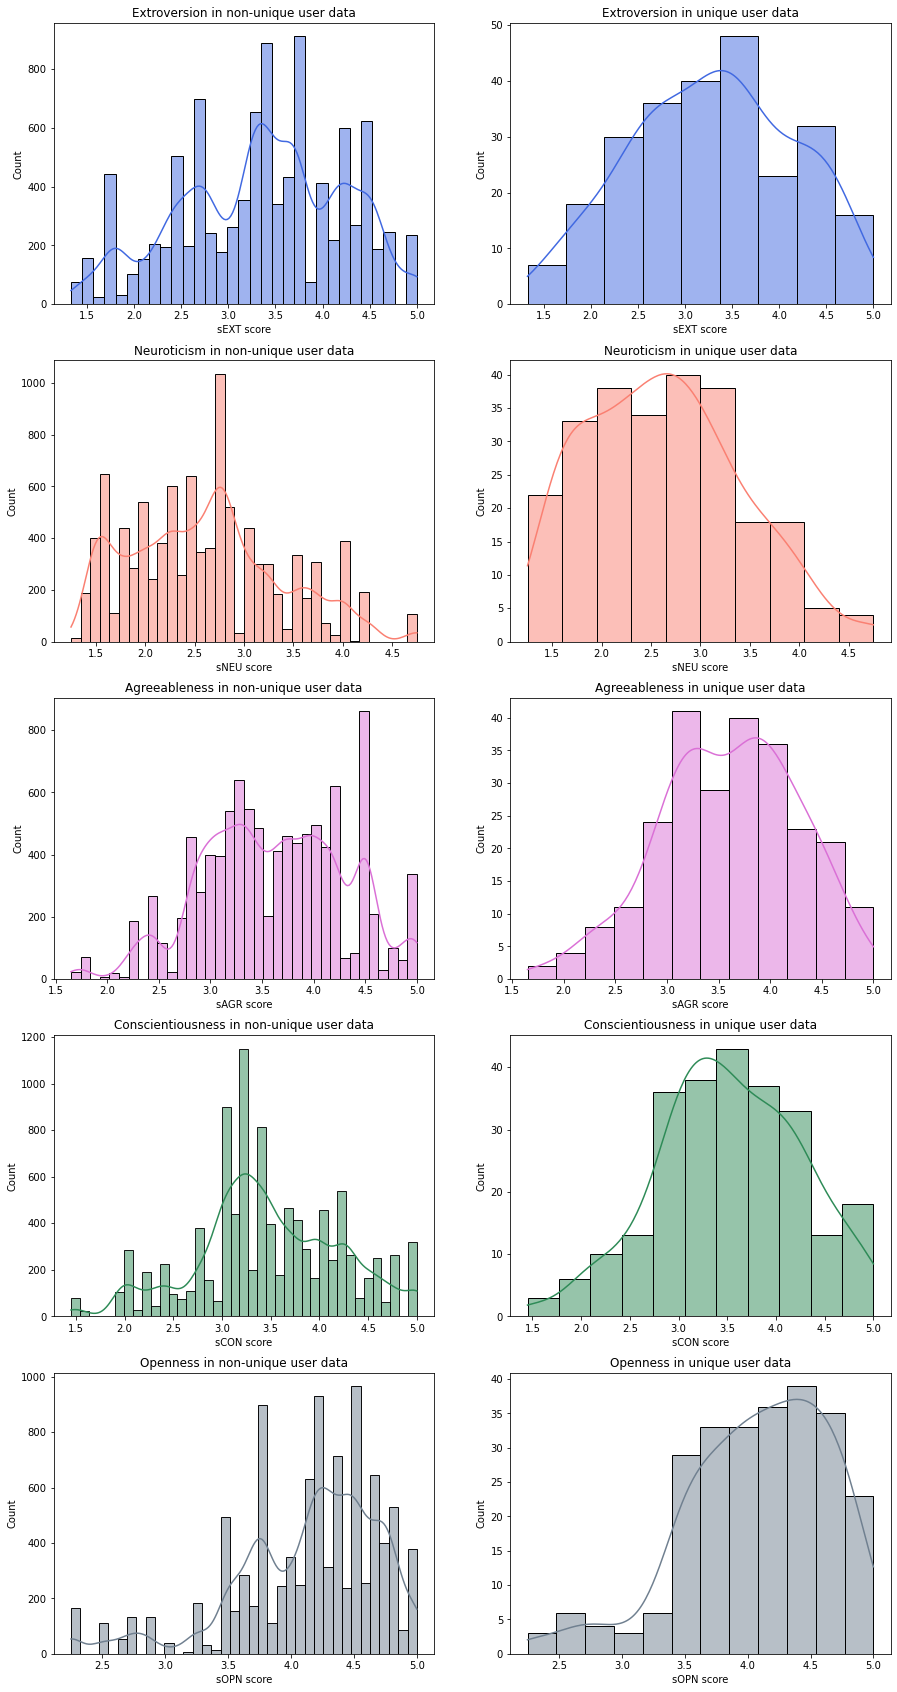

In [20]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15,30))
for i in range(5):
    sns.histplot(df[score_list[i]], kde=True, color = color_list[i],ax = ax[i][0])
    ax[i][0].set_title(f'{title_list[i]} in non-unique user data')
    ax[i][0].set_xlabel(f'{score_list[i]} score')
    sns.histplot(unique_users[score_list[i]], kde=True, color = color_list[i], ax = ax[i][1])
    ax[i][1].set_title(f'{title_list[i]} in unique user data')
    ax[i][1].set_xlabel(f'{score_list[i]} score')

In [21]:
# The distribution from data with unique user is difference than non-unique user distribution
# Futher compare the distribution with skew of each distribution
skew_df = pd.DataFrame(columns=['non-unique','unique'])
for index in score_list:
    skew_df.loc[index] = [df[index].skew(),unique_users[index].skew()]
skew_df

,non-unique,unique
sEXT,-0.232282,-0.103362
sNEU,0.424515,0.411209
sAGR,-0.124769,-0.285312
sCON,-0.088574,-0.166845
sOPN,-1.049216,-0.784900


**Use the `.describe()` method on `unique_users`:**

In [22]:
unique_users.describe().round(2)

,sEXT,sNEU,sAGR,sCON,sOPN
count,250.00,250.00,250.00,250.00,250.00
mean,3.29,2.63,3.60,3.52,4.08
std,0.86,0.78,0.67,0.74,0.58
min,1.33,1.25,1.65,1.45,2.25
25%,2.66,2.00,3.15,3.00,3.75
50%,3.30,2.59,3.66,3.50,4.15
75%,4.00,3.15,4.10,4.05,4.50
max,5.00,4.75,5.00,5.00,5.00


### Plots vs. Tables

Consider what different information is easily conveyed by the plots of scores, versus the table with summary statistics. Explain when you might present a distribution versus when you might present a table of summary statistics.

In [23]:
# The plots of score give infomation about the distribution of the score.
# The table with summary statistics provide precise infomation about
# mean, median, min and max value of the score.

# The distribution is used to see the skew of the data.
# The table of summary statistics is used when you need to explore
# overall of the data.

#### Other visualizations:

Create 1-2 additional visualizations related to the `unique_users` dataframe.

You might consider:
- Bar charts of users per category per trait
- Seaborn correlation heatmap
- Seaborn pairplot

In [24]:
score_list_category = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']

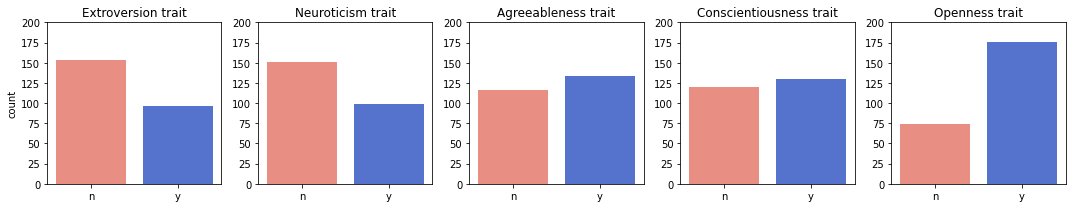

In [25]:
# Bar charts of users per category per trait
fig, ax = plt.subplots(ncols = 5, figsize=(15,3))
for i, col in enumerate(score_list_category):
    sns.countplot(x=col, 
                  data=unique_users,
                  order = ['n','y'],
                  palette= ['salmon','royalblue'],
                  ax = ax[i])
    ax[i].set(ylim=(0,200), title = f'{title_list[i]} trait')
    ax[i].set_xlabel('')
    if i > 0:
        ax[i].set_ylabel('')
plt.tight_layout()

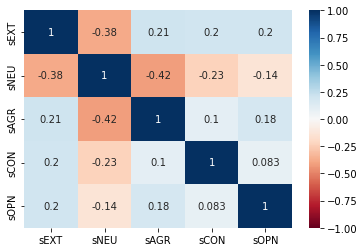

In [26]:
# Seaborn correlation heatmap
sns.heatmap(data=unique_users.corr(),
            annot=True,
            vmin=-1,
            vmax=1,
            cmap='RdBu');

---

## Exploring status length and word count based on personality

**Using `groupby()`, find the mean status length and status word count for posts by users in the high and low categories of each of the Big 5 traits.**

You'll need to use `groupby()` five separate times for this.

In [27]:
# Extroversion: outgoing/energetic(y) vs. solitary/reserved(n)
df.groupby(['cEXT']).mean()[['status_length','status_word_count']]

,status_length,status_word_count
cEXT,,
n,79.866655,14.659891
y,81.704918,14.843906


In [28]:
# Neuroticism: sensitive/nervous(y) vs. resilient/confident(n)
df.groupby(['cNEU']).mean()[['status_length','status_word_count']]

,status_length,status_word_count
cNEU,,
n,80.852396,14.753025
y,80.304278,14.712941


In [29]:
# Agreeableness: friendly/compassionate(y) vs. critical/rational(n)
df.groupby(['cAGR']).mean()[['status_length','status_word_count']]

,status_length,status_word_count
cAGR,,
n,80.976769,14.857389
y,80.355800,14.632618


In [30]:
# Conscientiousness: efficient/organized(y) vs. extravagant/careless(n)
df.groupby(['cCON']).mean()[['status_length','status_word_count']]

,status_length,status_word_count
cCON,,
n,81.920149,14.969963
y,79.149034,14.465101


In [31]:
# Openness: inventive/curious(y) vs. consistent/cautious(n)
df.groupby(['cOPN']).mean()[['status_length','status_word_count']]

,status_length,status_word_count
cOPN,,
n,85.686298,15.653318
y,78.905143,14.421631


**Choose one of the personality category columns (i.e. `cOPN`, `cCON`, `cEXT`, `cAGR`, or `cNEU`.) Use `sns.distplot()` to visualize the distribution of status word counts for posts by users who score both high (`y`) and low (`n`) in that personality category:**

<Figure size 432x288 with 0 Axes>

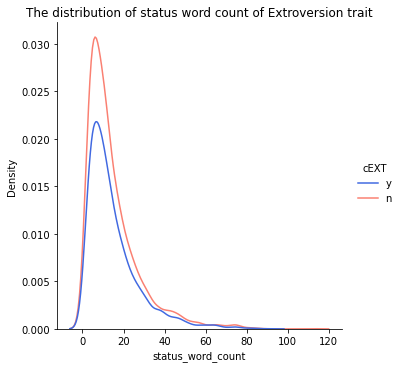

<Figure size 432x288 with 0 Axes>

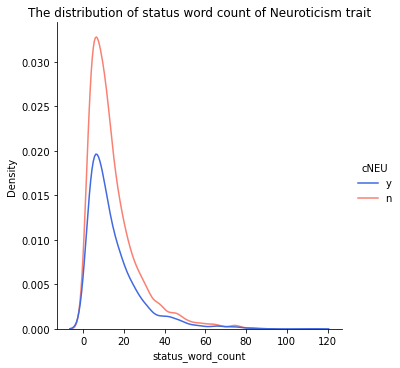

<Figure size 432x288 with 0 Axes>

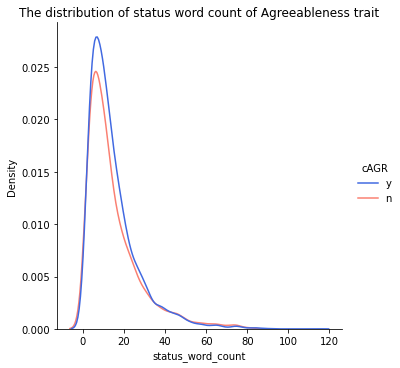

<Figure size 432x288 with 0 Axes>

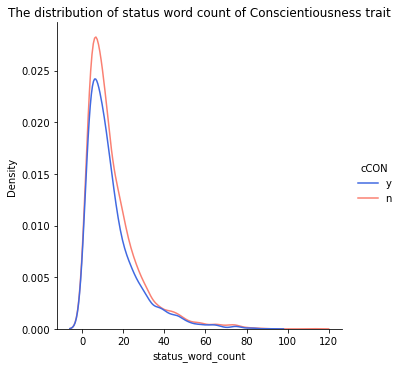

<Figure size 432x288 with 0 Axes>

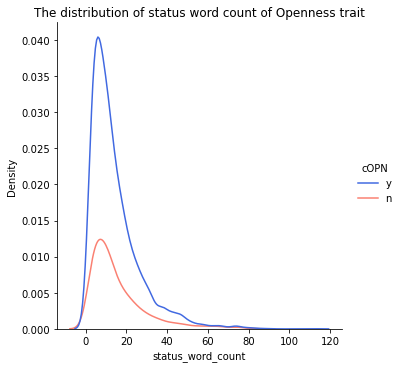

In [32]:
for i, col in enumerate(score_list_category):
    plt.figure()
    sns.displot(x='status_word_count',
                data=df,
                kind='kde',
                palette=['royalblue','salmon'],
                hue=col,
                hue_order = ['y','n'])
    plt.title(f'The distribution of status word count of {title_list[i]} trait');

---

## EDA on Word Counts

### Vectorize the text

In order to perform EDA on word count data, we'll need to count-vectorize.

Create a dataframe that contains the count-vectorized text for each Facebook status in the dataset.

To do this, you might follow these steps:
- Instantiate a `CountVectorizer` object
- Fit the count vectorizer on the Facebook statuses
- Store the transformed data
- Convert to a dataframe and store
    - Don't forget that the transformed data will need to be 'densified'. The `toarray()` or `todense()` methods will allow this.
    - Don't forget that the `get_feature_names()` method on a fitted `CountVectorizer` object will bring you back the words learned from the dataset, which you can set as the `columns` argument when creating the dataframe.
    
It's up to you whether or not to keep stopwords in the dataset.

In [33]:
df.columns

Index(['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN', 'DATE', 'status_length',
       'status_word_count'],
      dtype='object')

In [90]:
# Instantiate
cvec = CountVectorizer(stop_words='english')

# Fit and transform
X = cvec.fit_transform(df['STATUS'])

In [91]:
# Convert sparse matrix to dataframe
X_df = pd.DataFrame(X.todense(),
                    columns=cvec.get_feature_names_out()) 

In [92]:
X_df.head()

,00,000,000ft,00am,00pm,01,02,02pm,03,0330,...,équipe,étais,était,étant,état,été,être,østersund,últimas,últimos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Show the 15 most common words

In [93]:
X_df.sum().sort_values(ascending=False).head(15)

propname    1309
just         717
day          534
like         506
time         424
going        414
today        402
new          386
work         369
good         354
got          314
night        312
love         292
tomorrow     277
know         276
dtype: int64

### Show the 15 frequency of the most common words as a bar chart

**Hint**: You can do this in one line of code. [This webpage](https://dfrieds.com/data-visualizations/bar-plot-python-pandas.html) has an example.

In [211]:
X_df.sum().sort_values(ascending=False).head(15)

propname    1309
just         717
day          534
like         506
time         424
going        414
today        402
new          386
work         369
good         354
got          314
night        312
love         292
tomorrow     277
know         276
dtype: int64

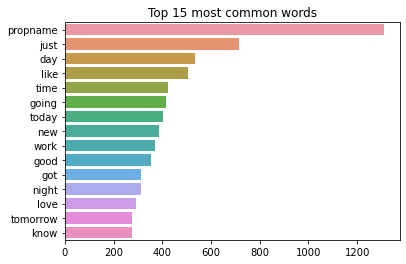

In [220]:
sns.barplot(x=X_df.sum().sort_values(ascending=False).head(15),
            y=X_df.sum().sort_values(ascending=False).head(15).index)\
            .set_title('Top 15 most common words');

### Investigating `propname`

The word `propname` shows up frequently in this dataset. Show the first 10 statuses in the dataset that contain `propname`:

In [208]:
df[X_df['propname'] > 0][['STATUS']].head(10)

,STATUS
6,"saw a nun zombie, and liked it. Also, *PROPNAME* + Tentacle!Man + Psychic Powers = GREAT Party."
18,"is tired. *PROPNAME*, let me go to sleep pl0x."
69,has a fair idea of how to manage the 2.5 kids cliche... She just needs a very strong gentleman named *PROPNAME* and thriteen wet napkins.
101,has a serious crush on *PROPNAME*. <3
104,Mondays are the new thursdays- anthony bourdain + *PROPNAME* = forgetting your financial troubles
118,is *PROPNAME*'s bestbian
139,is in love with *PROPNAME*.
158,is in love. With *PROPNAME*.
170,Ten Movies to Watch Right Now (and some you can Instant Netflix) 1. La Vie En Rose 2. Shrink (if you love LA) 3. Paris Je'taime (if you love Paris) 3. Clay Pidgeons (*PROPNAME* is priceless) 4. Quills 5. Away We Go 6. Sunshine Cleaning 7. A League of Their Own 8. Smart People (I Heart *PROPNAME*'s Page and SJP) 9. Frost//Nixon 10. Doubt
202,"ATTENTION EVERYONE!!! Vote for the short ""AFTER HOURS"" to support *PROPNAME* - our local Michigan talent and a wonderful person. Repost please!!! http:////www.thirteen.org//sites//reel13//category//vote//"


In [95]:
df[X_df['propname'] > 0][['STATUS']].head(10)

,STATUS
6,"saw a nun zombie, and liked it. Also, *PROPNAME* + Tentacle!Man + Psychic Powers = GREAT Party."
18,"is tired. *PROPNAME*, let me go to sleep pl0x."
69,has a fair idea of how to manage the 2.5 kids cliche... She just needs a very strong gentleman named *PROPNAME* and thriteen wet napkins.
101,has a serious crush on *PROPNAME*. <3
104,Mondays are the new thursdays- anthony bourdain + *PROPNAME* = forgetting your financial troubles
118,is *PROPNAME*'s bestbian
139,is in love with *PROPNAME*.
158,is in love. With *PROPNAME*.
170,Ten Movies to Watch Right Now (and some you can Instant Netflix) 1. La Vie En Rose 2. Shrink (if you love LA) 3. Paris Je'taime (if you love Paris) 3. Clay Pidgeons (*PROPNAME* is priceless) 4. Quills 5. Away We Go 6. Sunshine Cleaning 7. A League of Their Own 8. Smart People (I Heart *PROPNAME*'s Page and SJP) 9. Frost//Nixon 10. Doubt
202,"ATTENTION EVERYONE!!! Vote for the short ""AFTER HOURS"" to support *PROPNAME* - our local Michigan talent and a wonderful person. Repost please!!! http:////www.thirteen.org//sites//reel13//category//vote//"


**Provide a short explanation of what you believe `propname` to be:**

In [96]:
# A proper name is a noun or noun phrase 
# that designates a particular person, place, 
# or object and is always written capitalized

# Anonymized the person in the status
# https://github.com/nlp-psych/personality

## Most common words based on personality category

In order to do more targeted EDA, we'll need to be able to reference not only the dataframe of vectorized statuses, but also the personality scores from the original dataframe.

**Create a new dataframe called `text_and_scores` that concatenates the count-vectorized statuses side-by-side with the original personality category columns:**

In [97]:
df.columns

Index(['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN', 'DATE', 'status_length',
       'status_word_count'],
      dtype='object')

In [98]:
score_list_category

['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']

In [99]:
orginal_personal_df = df[score_list_category]
text_and_scores = pd.concat([orginal_personal_df,X_df],axis=1)
text_and_scores.head()

,cEXT,cNEU,cAGR,cCON,cOPN,00,000,000ft,00am,00pm,...,équipe,étais,était,étant,état,été,être,østersund,últimas,últimos
0,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Show the 25 most common words for statuses from high-cAGR users:**

In [100]:
text_and_scores[text_and_scores['cAGR'] == 'y'].drop(columns=score_list_category)\
.sum().sort_values(ascending=False).head(25)

propname    699
just        402
day         297
like        280
time        221
today       219
work        206
good        201
going       200
new         194
love        172
happy       165
night       161
know        157
got         157
people      156
tomorrow    153
life        140
home        131
tonight     129
really      127
don         119
want        108
weekend     105
ll          103
dtype: int64

**Show the 25 most common words for statuses from low-cAGR users:**

In [101]:
text_and_scores[text_and_scores['cAGR'] == 'n'].drop(columns=score_list_category)\
.sum().sort_values(ascending=False).head(25)

propname    610
just        315
day         237
like        226
going       214
time        203
new         192
today       183
work        163
got         157
good        153
night       151
home        136
don         134
tonight     127
tomorrow    124
life        120
love        120
really      119
know        119
people      112
think       110
want        109
happy       107
week         98
dtype: int64

### (BONUS) Most common bigrams:

This is a bonus section and not required (**_though highly recommended_**).

Find the 10 most common [bigrams](https://en.wikipedia.org/wiki/Bigram) in the dataset.

In [102]:
cvec_bigrams = CountVectorizer(ngram_range=(2,2),stop_words='english')
X_bigram = cvec_bigrams.fit_transform(df['STATUS'])

In [103]:
X_bigram_df = pd.DataFrame(X_bigram.todense(),
                           columns = cvec_bigrams.get_feature_names_out())
X_bigram_df.head(1)

,00 00,00 01,00 300,00 58,00 bills,00 friday,00 glee,00 gotta,00 min,00 outside,...,étant donné,étant pauvre,état unis,été est,être apprécié,être enforme,être quoi,østersund time,últimas hojas,últimos días
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
X_bigram_df.sum().sort_values(ascending=False).head(10)

propname propname    147
just got              55
new year              53
http www              46
merry christmas       44
looking forward       43
feel like             39
happy new             32
don know              31
birthday wishes       29
dtype: int64

### (BONUS) Most common trigrams:

This is a bonus section and not required (**_though highly recommended_**).

Find the 10 most common [trigrams](https://en.wikipedia.org/wiki/Trigram) in the dataset.

In [109]:
cvec_trigrams = CountVectorizer(ngram_range=(3,3),stop_words='english')
X_trigram = cvec_trigrams.fit_transform(df['STATUS'])

In [110]:
X_trigram_df = pd.DataFrame(X_trigram.todense(),
                           columns = cvec_trigrams.get_feature_names_out())
X_trigram_df.head(1)

,00 00 300,00 00 today,00 01 wddw,00 300 mins,00 58 midnight,00 bills op,00 friday nights,00 glee doesn,00 gotta love,00 min entire,...,étant donné qu,étant pauvre ai,état unis wow,été est fini,être apprécié le,être enforme pour,être quoi ce,østersund time walk,últimas hojas pero,últimos días en
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
X_trigram_df.sum().sort_values(ascending=False).head(10)

propname propname propname    54
gainesville film industry     23
www examiner com              23
http www examiner             23
24676 gainesville film        23
film industry examiner        23
happy new year                21
examiner com examiner         20
com examiner 24676            20
examiner 24676 gainesville    20
dtype: int64

---

## Choose your own adventure

By now you've looked at a lot of visualizations and frequency counts.

Come up with 2-3 questions about the data, and try to answer them using descriptive statistics (like counts, averages, etc.) or visualizations.

Some questions you might explore:
- Have numbers been redacted, or are phone numbers, house numbers, or zip codes anywhere in the dataset?
- `PROPNAME` has been used to redact personal names. Given that this data was scraped between 2009 and 2011, investigate if any public figures or famous people show up in the dataset, or their names have been redacted as well.
- Is count of uppercase letters vs. lowercase letters per status related to any personality category or personality score?
- Is _average_ word count per status related to any personality category or personality metric?
- Is punctuation use related to personality?

Or, of course, come up with your own questions to investigate!

The focus here is on "explore" -- you might not find anything of particular interest, but don't let that discourage you.

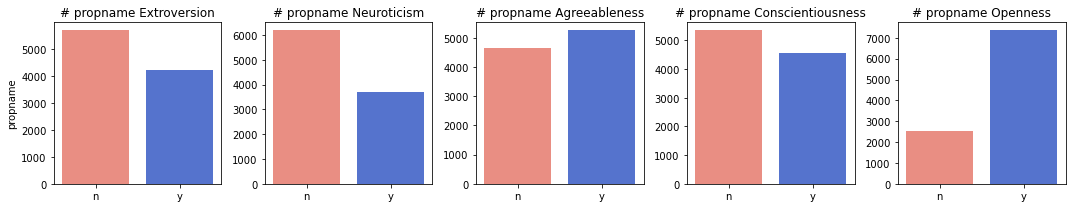

In [237]:
# Is person for each persionality usually use PROPNAME in the status?

fig, ax = plt.subplots(ncols = 5, figsize=(15,3))
for i, col in enumerate(score_list_category):
    sns.barplot(data=text_and_scores.groupby([col]).count()[['propname']],
                x=text_and_scores.groupby([col]).count()[['propname']].index,
                y='propname',
                palette=['salmon','royalblue'],
                ax=ax[i])
    ax[i].set_title(f'# propname {title_list[i]}')
    ax[i].set_xlabel('')
    if i > 0:
        ax[i].set_ylabel('')
plt.tight_layout();

# Person for each personality use propname inequally.

In [180]:
# Is punctuation use related to personality?
import re

In [175]:
df['punctuation'] = df['STATUS'].map(lambda status: len(re.findall('[^\w\s]',status)))

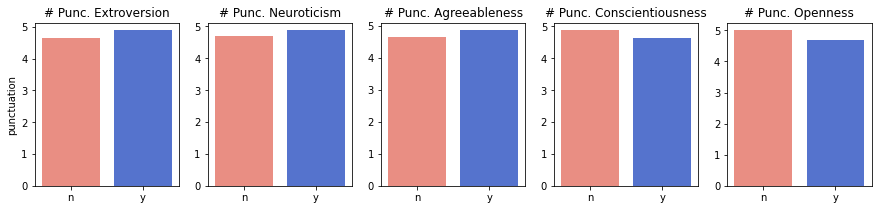

In [235]:
fig, ax = plt.subplots(ncols = 5, figsize=(15,3))
for i, col in enumerate(score_list_category):
    sns.barplot(data=df.groupby(col).mean()[['punctuation']],
                x=df.groupby(col).mean()[['punctuation']].index,
                y='punctuation',
                palette=['salmon','royalblue'],
                ax=ax[i])
    ax[i].set_title(f'# Punc. {title_list[i]}')
    ax[i].set_xlabel('')
    if i > 0:
        ax[i].set_ylabel('')

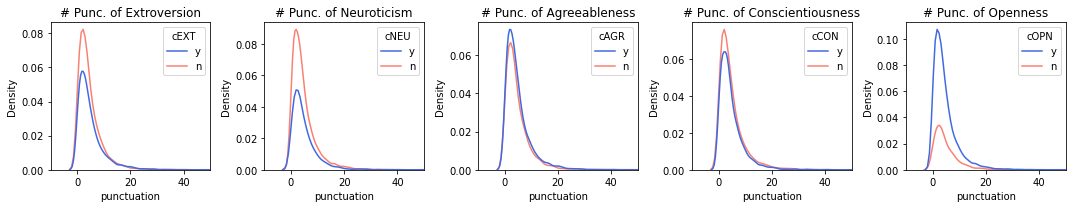

In [203]:
fig, ax = plt.subplots(ncols = 5, figsize=(15,3))
for i, col in enumerate(score_list_category):
    sns.kdeplot(x='punctuation',
                data = df,
                hue=col,
                hue_order=['y','n'],
                palette=['royalblue','salmon'],
                ax=ax[i])
    ax[i].set_xlim(-10,50)
    ax[i].set_title(f'# Punc. of {title_list[i]}')
plt.tight_layout();

In [ ]:
# Is punctuation use related to personality?
# From data exploration above, Using puntuation isn't related to personality.

---

## Exploratory vs. Explanatory Data Analysis 

> **Exploratory analysis** is what you do to get familiar with the data. You may start out with a hypothesis or question, or you may just really be delving into the data to determine what might be interesting about it. Exploratory analysis is the process of turning over 100 rocks to find perhaps 1 or 2 precious gemstones.
>
> **Explanatory analysis** is what happens when you have something specific you want to show an audience - probably about those 1 or 2 precious gemstones. In my blogging and writing, I tend to focus mostly on this latter piece, explanatory analysis, when you've already gone through the exploratory analysis and from this have determined something specific you want to communicate to a given audience: in other words, when you want to tell a story with data.

- Cole Nussbaumer Knaflic, [exploratory vs. explanatory analysis](http://www.storytellingwithdata.com/blog/2014/04/exploratory-vs-explanatory-analysis)

### Choose one visual to explain:

Now that you've performed an exploratory data analysis, choose a visual (or 1-3 related visuals) to frame as **_explanatory_**. This can be a visual you created above, or you can create a new visual. For this visual, make sure the visuals are formatted clearly, and provide a one to two paragraph explanation/interpretation of the visual.

### Key finding
**1. 15 most common words in the sample of facebook status**

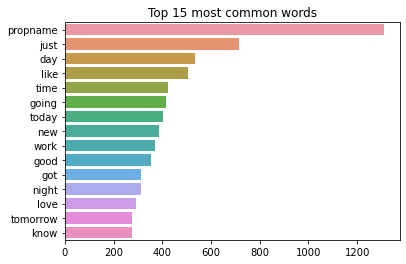

In [240]:
# Top 15 most common words bar chart
sns.barplot(x=X_df.sum().sort_values(ascending=False).head(15),
            y=X_df.sum().sort_values(ascending=False).head(15).index)\
            .set_title('Top 15 most common words');

The bar chart above displays 15 most common word in this sample. People tend to refer to other people in the facebook status. The other word e.g. day, going, new, etc. may be the common word to share something to their friend. 

**2.Number of people with high and low score in each traits**

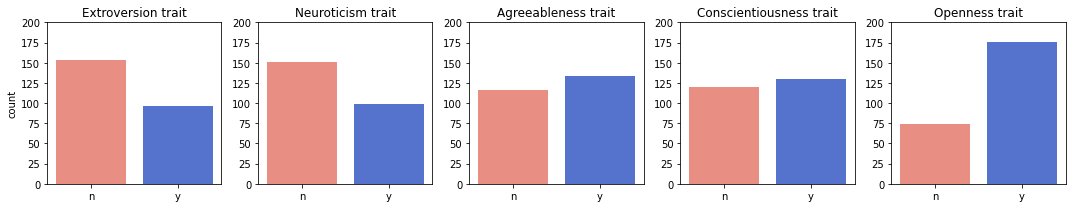

In [238]:
# Bar charts of users per category per trait
fig, ax = plt.subplots(ncols = 5, figsize=(15,3))
for i, col in enumerate(score_list_category):
    sns.countplot(x=col, 
                  data=unique_users,
                  order = ['n','y'],
                  palette= ['salmon','royalblue'],
                  ax = ax[i])
    ax[i].set(ylim=(0,200), title = f'{title_list[i]} trait')
    ax[i].set_xlabel('')
    if i > 0:
        ax[i].set_ylabel('')
plt.tight_layout()

In this data set, Amount of people in extroversion, neuriticism, and openness trait are significantly differnce between high and low score. For agreeable and conscientiousness trait, there are not much between low and high score.

**3. Using propname for each personality traits**

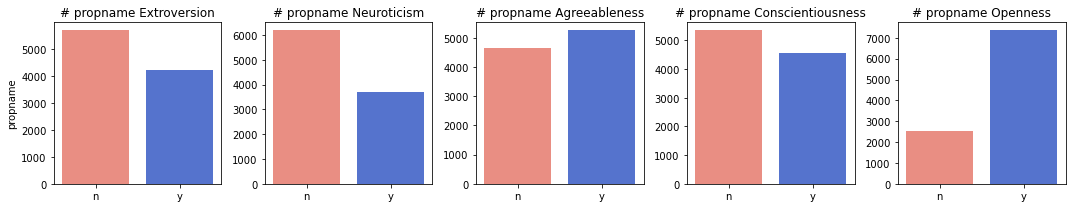

In [239]:
fig, ax = plt.subplots(ncols = 5, figsize=(15,3))
for i, col in enumerate(score_list_category):
    sns.barplot(data=text_and_scores.groupby([col]).count()[['propname']],
                x=text_and_scores.groupby([col]).count()[['propname']].index,
                y='propname',
                palette=['salmon','royalblue'],
                ax=ax[i])
    ax[i].set_title(f'# propname {title_list[i]}')
    ax[i].set_xlabel('')
    if i > 0:
        ax[i].set_ylabel('')
plt.tight_layout();

The people with high score in traits extroversion, neuroticism and openness tend to use propname in status were using the propname in the status difference than low score in personality trait. In extroversion and neuroticism traits, people with low score tend to use propname more frequency than high score people. In contrast, people in openness trait with low score tend to use propname in the status less than high score people.